In [204]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta

In [205]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [206]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect, distinct
from sqlalchemy import inspect


In [207]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [208]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [209]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [210]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [211]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [212]:
# details of the Measurement table
columns = inspect(engine).get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [213]:
# details of the Station table
columns = inspect(engine).get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [214]:
import datetime
# Find the most recent date in the data set. Only Measurement got a date value.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

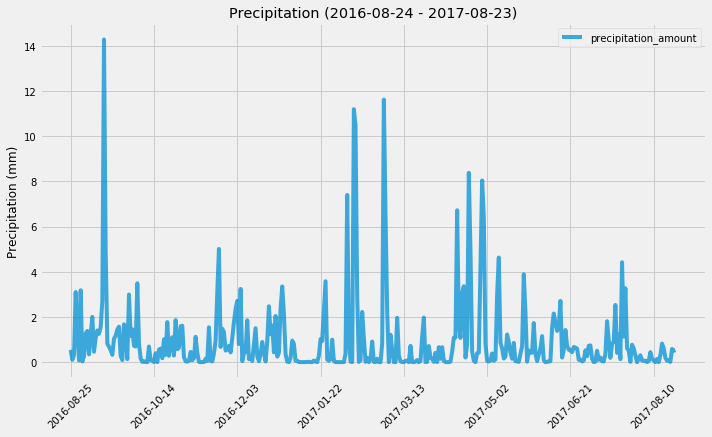

In [215]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
end_date=datetime.datetime.strptime(most_recent_date[0],"%Y-%m-%d")
before_12_months = end_date - relativedelta(years=1)+ timedelta(days=1)
end_date-before_12_months
# Calculate the date one year from the last date in data set.
(end_date-before_12_months).days

# Perform a query to retrieve the data and precipitation scores
# sel = [Measurement.date, func.sum(Measurement.prcp)]
precipitation = session.query(Measurement.date, func.sum(Measurement.prcp)).filter(func.strftime(Measurement.date) >= before_12_months).group_by(Measurement.date).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation, columns=['measurement_date', 'precipitation_amount'])
precipitation_df.set_index('measurement_date', inplace=True)


# Sort the dataframe by date
precipitation_df.sort_values(by='measurement_date')
precipitation_df.head()


# Use Pandas Plotting with Matplotlib to plot the data
plt.rc('font', size=10) 
precipitation_df.plot(kind="line", alpha=0.75,rot=45,figsize=(10, 6.18))
plt.title(f"Precipitation ({before_12_months.date()} - {end_date.date()})")
plt.xlabel(None)
plt.ylabel("Precipitation (mm)")
plt.tight_layout()
plt.savefig(f"Output/Precipitation ({before_12_months.date()} - {end_date.date()}).png")  


In [216]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation_amount
count,364.000000
mean,0.951209
std,1.723849
min,0.000000
25%,0.050000
50%,0.395000
75%,1.080000
max,14.280000


# Exploratory Station Analysis

In [217]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(func.count(distinct(Station.station))).first()[0]
total_stations

9

In [218]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_stations = active_stations[0]
most_active_stations


('USC00519281', 2772)

In [219]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest_tobs = round(session.query(Measurement.station,func.min(Measurement.tobs)
                                  .filter(Measurement.station== most_active_stations[0]))[0][1],2)

highest_tobs = round(session.query(Measurement.station,func.max(Measurement.tobs)
                                   .filter(Measurement.station== most_active_stations[0]))[0][1],2)

average_tobs = round(session.query(Measurement.station,func.avg(Measurement.tobs)
                                   .filter(Measurement.station== most_active_stations[0]))[0][1],2)

print(f'The lowest temperature is {lowest_tobs}, highest temperature is {highest_tobs} and average temperature is {average_tobs}.')



The lowest temperature is 54.0, highest temperature is 85.0 and average temperature is 71.66.


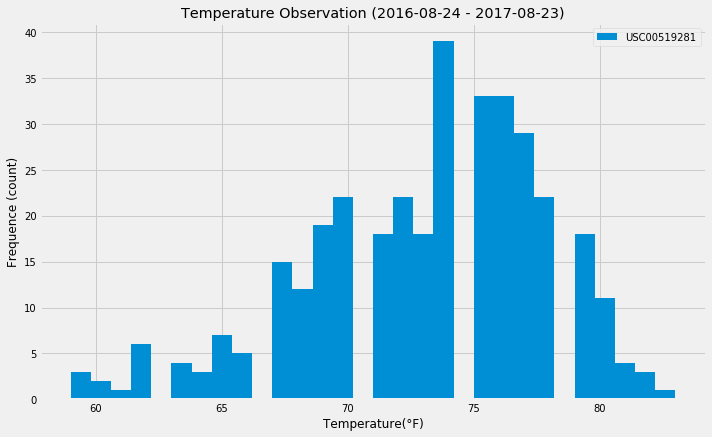

In [222]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_most_active = session.query(Measurement.date, Measurement.tobs).filter(func.strftime(Measurement.date) >= before_12_months).filter(Measurement.station== most_active_stations[0]).all()
temperature_most_active

temperature_most_active_df = pd.DataFrame(temperature_most_active, columns=['measurement_date', 'measurement_temperature'])
temperature_most_active_df.set_index('measurement_date', inplace=True)

plt.rc('font', size=10) 
temperature_most_active_df.hist(bins=30,label=f"{most_active_stations[0]}",figsize=(10, 6.18))
plt.legend()
#set up the layout for barchart
plt.ylabel("Frequence (count)")
plt.xlabel("Temperature(°F)")
plt.title(f"Temperature Observation ({before_12_months.date()} - {end_date.date()})")
plt.tight_layout()
plt.savefig(f"Output/Temperature Observation ({before_12_months.date()} - {end_date.date()}).png")


# Close session

In [203]:
# Close Session
session.close()